In [1]:
from glob import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [40]:
ticker = 'AAPL'

save_dir = '/data/kai/forecasting/results'
os.makedirs(save_dir, exist_ok=True)
def convert_to_float(values):
    return np.array([[float(num) for num in val.replace(' ', '').split(',')] for val in values])


maes = []
mses = []
rmses = []
rmaes = []

for baseline_path in sorted(glob(save_dir + '/*.csv')):
    if "AMZN" in baseline_path: continue
    df = pd.read_csv(baseline_path)

    results = convert_to_float(df['Result'].values)
    ground_truth = convert_to_float(df['Ground Truth'].values)

    
    # max_truth = ground_truth.max(1)[:, np.newaxis]
    min_truth = ground_truth.min(1)[:, np.newaxis]

    # normalized_results = (results - max_truth) / (max_truth - min_truth)
    # normalized_truth = (ground_truth - max_truth) / (max_truth - min_truth)
    # mae = np.mean(np.abs(normalized_results - normalized_truth), axis=1)
    # mse = np.mean(np.square(normalized_results - normalized_truth), axis=1)

    # maes.append(mae.mean())
    # mses.append(mse.mean())
    # print(baseline_path, mae.mean(), mse.mean())

    mse = np.mean(np.square((results / min_truth)- (ground_truth / min_truth)))
    mae = np.mean(np.abs((results / min_truth)- (ground_truth / min_truth)))
    rmses.append(mse)
    rmaes.append(mae)
    # rmse_sum += rmse
    # rmse_sum += rmse

    # break

In [43]:
np.std(rmaes), np.mean(rmaes)

(0.015646505920147158, 0.04342552013963185)

In [41]:
np.mean(rmses) * 100, np.mean(rmaes) * 100

(0.45521268338704407, 4.342552013963185)

In [30]:
[r for r in rmses]

[array([[8.74813031e-04, 2.23483516e-04, 1.11790852e-03, 1.78727382e-03,
         5.61114421e-03],
        [6.04466049e-03, 9.22991427e-03, 6.44259327e-03, 9.85898759e-04,
         4.92082330e-04],
        [1.01641489e-03, 1.03356927e-05, 3.23806917e-03, 5.82179711e-03,
         3.84994218e-03],
        ...,
        [2.48474490e-03, 3.10814304e-03, 5.22688092e-03, 3.76544369e-03,
         1.19642406e-02],
        [4.51466827e-06, 7.76452919e-04, 3.20126466e-03, 3.95811757e-03,
         6.33747060e-03],
        [7.47408348e-04, 3.15335758e-03, 3.90229867e-03, 6.26678707e-03,
         4.77560791e-03]]),
 array([[1.33050792e-06, 5.71789885e-05, 1.52803086e-05, 3.21950065e-06,
         1.84341051e-05],
        [1.62594537e-04, 1.80693038e-04, 3.89021111e-04, 2.60603425e-04,
         1.96211112e-04],
        [6.80907298e-05, 8.95256502e-04, 1.21698284e-03, 1.96643993e-03,
         2.01432713e-03],
        ...,
        [5.67103833e-04, 9.29897247e-04, 7.57636947e-04, 1.06702370e-04,
        

In [5]:
for i in range(10):

    max_truth = ground_truth[i].max()
    min_truth = ground_truth[i].min()

    norm = 

[88.34 89.12 90.51 91.95 93.42] [82.79 85.36 84.92 81.88 77.22]
[88.45 90.12 91.85 93.59 95.33] [84.92 81.88 77.22 76.93 82.2 ]
[83.15 84.51 86.23 87.95 89.67] [77.22 76.93 82.2  81.84 83.13]
[86.54 88.19 89.83 91.42 93.05] [81.88 77.22 76.93 82.2  81.84]
[82.19 81.42 80.85 80.29 79.73] [85.36 84.92 81.88 77.22 76.93]
[80.15 82.51 84.83 87.19 89.55] [76.93 82.2  81.84 83.13 83.38]
[83.55 84.89 85.21 86.53 87.82] [81.84 83.13 83.38 85.2  82.81]
[83.41 84.29 85.15 85.97 86.79] [83.13 83.38 85.2  82.81 82.37]
[84.51 85.23 86.12 85.92 86.45] [83.38 85.2  82.81 82.37 83.78]
[76.45 75.89 75.32 74.75 74.18] [82.2  81.84 83.13 83.38 85.2 ]


In [67]:
np.mean(maes), np.mean(mses)

(1.0425810339964425, 2.4183926902957045)

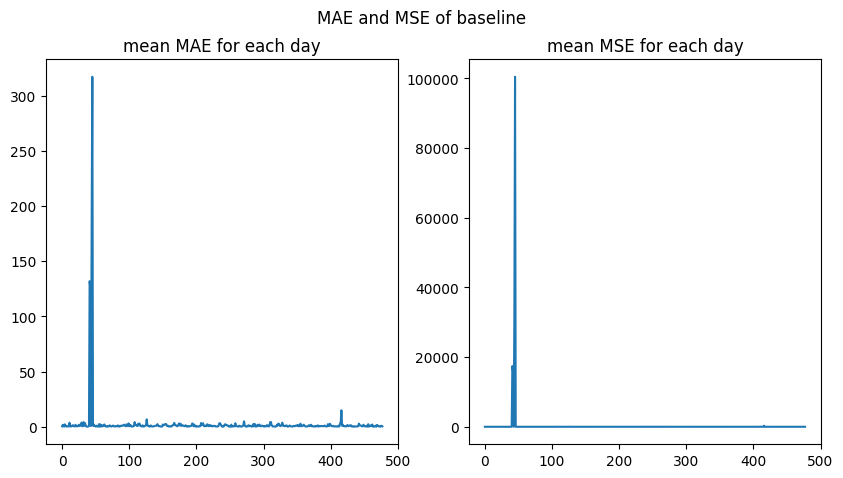

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(mae)
axs[0].set_title("mean MAE for each day")

axs[1].plot(mse)
axs[1].set_title("mean MSE for each day")

plt.suptitle("MAE and MSE of baseline")
plt.show()

In [11]:
np.argmax(res)
results[250], ground_truth[250]

(array([246.19, 249.15, 251.83, 254.49, 257.17]),
 array([239.24, 237.03, 233.52, 232.78, 233.27]))

In [8]:
def get_strict_trend(arr):
    # Check for strictly increasing
    strictly_increasing = np.all(np.diff(arr, axis=1) > 0, axis=1)

    # Check for strictly decreasing
    strictly_decreasing = np.all(np.diff(arr, axis=1) < 0, axis=1)

    # Combine the two conditions
    is_monotone = strictly_increasing | strictly_decreasing
    print('Increasing:', strictly_increasing.mean())
    print('Decreasing:', strictly_decreasing.mean())
    print('Both:', is_monotone.mean())
    return strictly_increasing, strictly_decreasing, is_monotone

In [9]:
pred_trend = get_strict_trend(results)
ground_truth_trend = get_strict_trend(ground_truth)

Increasing: 0.8279569892473119
Decreasing: 0.08602150537634409
Both: 0.9139784946236559
Increasing: 0.05806451612903226
Decreasing: 0.04946236559139785
Both: 0.10752688172043011
